In [1]:
gene_familly = "HRT-like"

In [2]:
# Parameters
gene_familly = "AP2"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn015881,MAYMNNWLGFSLSPQEHQNPQDHSQNSVSRLGFNTDKISGTDVSSD...,650,1
1,Achn066211,MLDLNLTAMPTDSISDGQMDDSGASNSSLLNVETSSVAVDEESSST...,405,1
2,Achn082221,MLDLNLSFARDEEYVSITEKFPEGSGGGAMDESGTSNSSIVNAEDD...,375,1
3,Achn088601,MEMITLVKSEVSPVRRRLCEMERDQKQPQQLLVDKSSATNTTVKRS...,312,1
4,Achn108581,MLDLNLSVVHNEDDSMEITNKFPEGSEGQMADSGTSTSSVVNAEGS...,426,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
8289,0.013216,0.00000,0.006608,0.004405,0.000000,0.011013,0.000000,0.002203,0.004405,0.002203,...,0.002203,0.006608,0.004405,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.0
7638,0.002433,0.00365,0.003650,0.006083,0.003650,0.002433,0.003650,0.002433,0.003650,0.004866,...,0.000000,0.001217,0.001217,0.000000,0.00365,0.00365,0.001217,0.0,0.0,0.0
7601,0.003521,0.00000,0.003521,0.007042,0.003521,0.000000,0.000000,0.003521,0.003521,0.003521,...,0.000000,0.003521,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.0
8799,0.004566,0.00000,0.000000,0.009132,0.004566,0.000000,0.004566,0.000000,0.000000,0.004566,...,0.000000,0.000000,0.000000,0.004566,0.00000,0.00000,0.000000,0.0,0.0,0.0
8759,0.008798,0.00000,0.002933,0.005865,0.005865,0.000000,0.000000,0.002933,0.000000,0.011730,...,0.002933,0.000000,0.000000,0.000000,0.00000,0.00000,0.002933,0.0,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 441)
X_test: (1779, 441)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 42s 481ms/step - accuracy: 0.5312 - loss: 0.6931

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6702 - loss: 0.6816   

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7445 - loss: 0.6281

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7772 - loss: 0.5760 - val_accuracy: 0.9543 - val_loss: 0.1098


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1127

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9613 - loss: 0.1254

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.1197

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9631 - loss: 0.1159 - val_accuracy: 0.9599 - val_loss: 0.0939


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0777

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.0720

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.0739

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.0748 - val_accuracy: 0.9670 - val_loss: 0.0838


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0421

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.0634

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0674

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 0.0676 - val_accuracy: 0.9684 - val_loss: 0.0819


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0291

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9782 - loss: 0.0506

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 0.0556

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0578 - val_accuracy: 0.9698 - val_loss: 0.0825


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0430

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0620

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0609

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9782 - loss: 0.0602 - val_accuracy: 0.9628 - val_loss: 0.1103


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0436

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0507

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0526

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0527 - val_accuracy: 0.9705 - val_loss: 0.0918


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0074

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0413

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.0474

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0484 - val_accuracy: 0.9747 - val_loss: 0.0778


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0234

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0359

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0370

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0374 - val_accuracy: 0.9726 - val_loss: 0.0854


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0121

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0324

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0338

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0333 - val_accuracy: 0.9733 - val_loss: 0.0897


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0098

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0226

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0265

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0272 - val_accuracy: 0.9761 - val_loss: 0.0924


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0110

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0156

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.0188

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0196 - val_accuracy: 0.9747 - val_loss: 0.0916


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9969 - loss: 0.0127

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0129

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0130 - val_accuracy: 0.9754 - val_loss: 0.0952


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0751

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0194

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0170

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0159 - val_accuracy: 0.9754 - val_loss: 0.1046


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0067

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0095

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0104 - val_accuracy: 0.9754 - val_loss: 0.1035


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0144

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0138

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0127

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0124 - val_accuracy: 0.9726 - val_loss: 0.1096


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0022

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0291

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0237

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0223 - val_accuracy: 0.9726 - val_loss: 0.1069


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0030

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0160

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0131

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0120 - val_accuracy: 0.9677 - val_loss: 0.1433


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5294e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0218    

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0193

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0178 - val_accuracy: 0.9747 - val_loss: 0.1160


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5743e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0062    

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0093

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0096 - val_accuracy: 0.9740 - val_loss: 0.1207


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0044

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0046

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0045 - val_accuracy: 0.9733 - val_loss: 0.1316



[Train Accuracy: 99.89% - Test Accuracy: 97.19%]


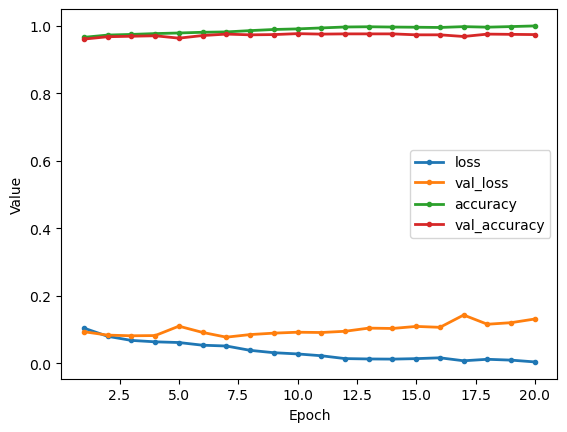

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
8289,0.002208,0.0,0.002208,0.002208,0.000000,0.002208,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7638,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001218,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7601,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8799,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.004587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8759,0.000000,0.0,0.000000,0.000000,0.002941,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 8898)
X_test: (1779, 8898)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,278,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,321,409 (8.86 MB)

 Trainable params: 2,321,409 (8.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 53s 613ms/step - accuracy: 0.5156 - loss: 0.6931

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5144 - loss: 0.6929   

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5664 - loss: 0.6915

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6210 - loss: 0.6878

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6642 - loss: 0.6798

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6971 - loss: 0.6649

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7230 - loss: 0.6433

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7440 - loss: 0.6186

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7612 - loss: 0.5939

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7680 - loss: 0.5832

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7758 - loss: 0.5703

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7869 - loss: 0.5507

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7881 - loss: 0.5484 - val_accuracy: 0.9698 - val_loss: 0.0768


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.1685

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9794 - loss: 0.0852 

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9813 - loss: 0.0715

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9816 - loss: 0.0657

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9818 - loss: 0.0621

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9819 - loss: 0.0601

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9820 - loss: 0.0586

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9822 - loss: 0.0574

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9825 - loss: 0.0560

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9827 - loss: 0.0549

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9828 - loss: 0.0540

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9829 - loss: 0.0536 - val_accuracy: 0.9761 - val_loss: 0.0684


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0135

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0105 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0117

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.0117

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0115

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0118

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0121

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0122

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0124

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9970 - loss: 0.0127

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9968 - loss: 0.0130 - val_accuracy: 0.9796 - val_loss: 0.0709


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0145

 7/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9982 - loss: 0.0118 

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9976 - loss: 0.0122

13/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9976 - loss: 0.0121

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9978 - loss: 0.0112

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9980 - loss: 0.0104

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9982 - loss: 0.0098

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9981 - loss: 0.0102

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0103 

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0102

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0100

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0099

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0098

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9982 - loss: 0.0097 - val_accuracy: 0.9782 - val_loss: 0.0748


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 8.5932e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011     

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0016

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0020

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0026

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0031

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0034

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0034

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0035

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0037

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0037

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 0.9796 - val_loss: 0.0786


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0040

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9970 - loss: 0.0170 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.0123

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0100

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0087

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0079

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0071

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0066

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0062

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0059

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9796 - val_loss: 0.0829


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 9.9339e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011     

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

48/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0010

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0010

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8844e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7771e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 9.7658e-04 - val_accuracy: 0.9768 - val_loss: 0.1044


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0043

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0021 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6087e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1103e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6697e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2903e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.9876e-04 - val_accuracy: 0.9796 - val_loss: 0.0953


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.5650e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3247e-04 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3995e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4371e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4968e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5373e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5766e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6030e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6214e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6330e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.6379e-04 - val_accuracy: 0.9803 - val_loss: 0.0987


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.7914e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4319e-04 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 3.6493e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 5.0816e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 5.6506e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 5.7562e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 5.7060e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 5.5873e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 5.4460e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 5.3140e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 5.1667e-04 - val_accuracy: 0.9789 - val_loss: 0.1023


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.3941e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2927e-04 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6074e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2479e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0165e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8552e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7449e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6643e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6044e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5550e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5153e-04 - val_accuracy: 0.9796 - val_loss: 0.1043


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.2596e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0862e-04 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0625e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8423e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5872e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4466e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4069e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.3105e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2090e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1153e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.0955e-05 - val_accuracy: 0.9803 - val_loss: 0.1063


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 5.5091e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5604e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6609e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7302e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6053e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4661e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3508e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2453e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2010e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.1368e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.0918e-05 - val_accuracy: 0.9796 - val_loss: 0.1103


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.5278e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3225e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.0971e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9579e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8300e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.7259e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6496e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6373e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6062e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5500e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.5135e-05 - val_accuracy: 0.9796 - val_loss: 0.1117


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.3133e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1837e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2613e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5123e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6367e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6701e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7390e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8990e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0338e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1242e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.2066e-05 - val_accuracy: 0.9803 - val_loss: 0.1135


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 9.3162e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1300e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6603e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4897e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1903e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0571e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9066e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7045e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5067e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3192e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.1635e-05 - val_accuracy: 0.9810 - val_loss: 0.1164


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.6409e-06

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6283e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6565e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5571e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5444e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6061e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7260e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2213e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6358e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9718e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2151e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.2423e-05 - val_accuracy: 0.9789 - val_loss: 0.1222


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 1.7684e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8460e-05 

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9951e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0623e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1141e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1523e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2255e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3443e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4145e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4716e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5096e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.5503e-05 - val_accuracy: 0.9789 - val_loss: 0.1245


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 8.0171e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9853e-05 

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2884e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0717e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9358e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8932e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9014e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9233e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9234e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9271e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9191e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.9156e-05 - val_accuracy: 0.9810 - val_loss: 0.1244


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.5369e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9616e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9100e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8523e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8271e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8755e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8942e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9094e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9273e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9297e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9284e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.9287e-05 - val_accuracy: 0.9810 - val_loss: 0.1263


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.7883e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7726e-05 

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2921e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1238e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0364e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9783e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9508e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9375e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0137e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0709e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1166e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1468e-05 - val_accuracy: 0.9803 - val_loss: 0.1284


Epoch 22/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.9832e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6530e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3447e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1270e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9521e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8489e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7562e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6725e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5909e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5119e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4388e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3898e-05 - val_accuracy: 0.9810 - val_loss: 0.1312


Epoch 23/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.4255e-06

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8816e-06 

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0015e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0120e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0293e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0651e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0939e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1201e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1313e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1520e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1924e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2428e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2483e-05 - val_accuracy: 0.9810 - val_loss: 0.1332


Epoch 24/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.4056e-06

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4589e-06 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.9390e-06

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1960e-06

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.3945e-06

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5222e-06

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6953e-06

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8203e-06

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8395e-06

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9324e-06

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0023e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0043e-05 - val_accuracy: 0.9803 - val_loss: 0.1343


Epoch 25/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.4219e-06

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3929e-06 

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1918e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2983e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3022e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2978e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2836e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2646e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2539e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2551e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2515e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2473e-05 - val_accuracy: 0.9803 - val_loss: 0.1359


Epoch 26/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.9305e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5215e-05 

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1858e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1106e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0505e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0063e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6882e-06

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4810e-06

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.3741e-06

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2995e-06

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.2487e-06 - val_accuracy: 0.9810 - val_loss: 0.1380



[Train Accuracy: 100.00% - Test Accuracy: 97.98%]


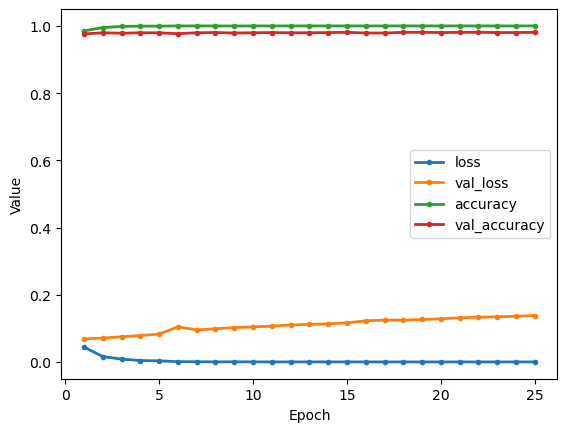

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
8289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,890,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,931,457 (148.51 MB)

 Trainable params: 38,931,457 (148.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 58s 670ms/step - accuracy: 0.5312 - loss: 0.6932

 2/89 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.5078 - loss: 0.6932 

 3/89 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.5087 - loss: 0.6931

 4/89 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.5133 - loss: 0.6930

 5/89 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.5157 - loss: 0.6929

 6/89 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.5178 - loss: 0.6928

 7/89 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.5198 - loss: 0.6927

 8/89 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5212 - loss: 0.6926

 9/89 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.5225 - loss: 0.6925

10/89 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.5246 - loss: 0.6923

11/89 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.5266 - loss: 0.6921

12/89 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.5276 - loss: 0.6920

13/89 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.5280 - loss: 0.6919

14/89 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5277 - loss: 0.6918

15/89 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.5269 - loss: 0.6917

16/89 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5262 - loss: 0.6916

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5256 - loss: 0.6915

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5251 - loss: 0.6914

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5251 - loss: 0.6913

20/89 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.5261 - loss: 0.6911

21/89 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.5277 - loss: 0.6909

22/89 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.5300 - loss: 0.6907

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.5326 - loss: 0.6905

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.5355 - loss: 0.6902

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.5384 - loss: 0.6899

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.5413 - loss: 0.6895

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.5440 - loss: 0.6892

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5467 - loss: 0.6888

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5495 - loss: 0.6884

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5525 - loss: 0.6879

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.5556 - loss: 0.6874

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5589 - loss: 0.6869

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5623 - loss: 0.6863

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5657 - loss: 0.6857

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5692 - loss: 0.6851

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5726 - loss: 0.6844

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5760 - loss: 0.6836

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5795 - loss: 0.6828

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5830 - loss: 0.6820

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5863 - loss: 0.6811

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5897 - loss: 0.6802

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5930 - loss: 0.6792

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5963 - loss: 0.6782

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5996 - loss: 0.6771

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.6028 - loss: 0.6759

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.6060 - loss: 0.6747

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.6091 - loss: 0.6734

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.6122 - loss: 0.6721

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.6153 - loss: 0.6707

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.6183 - loss: 0.6692

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.6213 - loss: 0.6677

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6242 - loss: 0.6661

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6271 - loss: 0.6644

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6300 - loss: 0.6627

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6328 - loss: 0.6609

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6355 - loss: 0.6590

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6383 - loss: 0.6572

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6410 - loss: 0.6552

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6436 - loss: 0.6533

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6462 - loss: 0.6512

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6488 - loss: 0.6492

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6513 - loss: 0.6471

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6538 - loss: 0.6450

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6562 - loss: 0.6429

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6586 - loss: 0.6407

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6610 - loss: 0.6386

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6633 - loss: 0.6364

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6655 - loss: 0.6342

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6678 - loss: 0.6320

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6700 - loss: 0.6298

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6722 - loss: 0.6276

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6743 - loss: 0.6253

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6764 - loss: 0.6231

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6785 - loss: 0.6208

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6806 - loss: 0.6186

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6826 - loss: 0.6163

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6846 - loss: 0.6140

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6866 - loss: 0.6118

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6885 - loss: 0.6095

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6904 - loss: 0.6073

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6923 - loss: 0.6050

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6941 - loss: 0.6028

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6960 - loss: 0.6005

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6978 - loss: 0.5983

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6995 - loss: 0.5961

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7013 - loss: 0.5938

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7030 - loss: 0.5916

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7048 - loss: 0.5894

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7064 - loss: 0.5872

89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.7081 - loss: 0.5850 - val_accuracy: 0.9698 - val_loss: 0.0798


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - accuracy: 0.9844 - loss: 0.0404

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.9766 - loss: 0.0490

 3/89 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.9757 - loss: 0.0521

 4/89 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.9759 - loss: 0.0524

 5/89 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.9764 - loss: 0.0525

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9764 - loss: 0.0531

 7/89 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9759 - loss: 0.0544

 8/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9755 - loss: 0.0553

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9755 - loss: 0.0556

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9756 - loss: 0.0555

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9759 - loss: 0.0554

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9761 - loss: 0.0556

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9763 - loss: 0.0559

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.9765 - loss: 0.0559

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.9768 - loss: 0.0558

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9772 - loss: 0.0557

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9775 - loss: 0.0555

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9778 - loss: 0.0554 

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.9780 - loss: 0.0552

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9783 - loss: 0.0550

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9785 - loss: 0.0548

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9787 - loss: 0.0547

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9788 - loss: 0.0547

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9790 - loss: 0.0546

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.9792 - loss: 0.0544

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.9793 - loss: 0.0543

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9795 - loss: 0.0541

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9796 - loss: 0.0540

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9797 - loss: 0.0539

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9799 - loss: 0.0537

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9800 - loss: 0.0536

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9802 - loss: 0.0534

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9803 - loss: 0.0532

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9804 - loss: 0.0530

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9806 - loss: 0.0528

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9807 - loss: 0.0526

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9808 - loss: 0.0524

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9809 - loss: 0.0522

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9810 - loss: 0.0520

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9812 - loss: 0.0517

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9813 - loss: 0.0515

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9814 - loss: 0.0513

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9815 - loss: 0.0511

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9816 - loss: 0.0510

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9817 - loss: 0.0508

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9818 - loss: 0.0506

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9819 - loss: 0.0505

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9819 - loss: 0.0503

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9820 - loss: 0.0502

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9821 - loss: 0.0501

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9821 - loss: 0.0500

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9822 - loss: 0.0499

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9822 - loss: 0.0498

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9823 - loss: 0.0496

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9823 - loss: 0.0495

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9824 - loss: 0.0494

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9825 - loss: 0.0492

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9825 - loss: 0.0491

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9826 - loss: 0.0490

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9827 - loss: 0.0488

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9827 - loss: 0.0487

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9828 - loss: 0.0486

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9829 - loss: 0.0484

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9829 - loss: 0.0483

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9830 - loss: 0.0482

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9830 - loss: 0.0481

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9831 - loss: 0.0480

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9831 - loss: 0.0478

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9832 - loss: 0.0477

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9832 - loss: 0.0476

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9833 - loss: 0.0475

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9833 - loss: 0.0473

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9834 - loss: 0.0472

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9834 - loss: 0.0471

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9835 - loss: 0.0470

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9835 - loss: 0.0469

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9836 - loss: 0.0467

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9836 - loss: 0.0466

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9837 - loss: 0.0465

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9837 - loss: 0.0464

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9838 - loss: 0.0463

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9838 - loss: 0.0461

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9839 - loss: 0.0460

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9839 - loss: 0.0459

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9840 - loss: 0.0458

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9840 - loss: 0.0457

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9841 - loss: 0.0456

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9841 - loss: 0.0455

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9841 - loss: 0.0454

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9842 - loss: 0.0453 - val_accuracy: 0.9824 - val_loss: 0.0480


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 1.0000 - loss: 0.0034

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 0.0042

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0044

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 0.0046

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 0.0046

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9996 - loss: 0.0052

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9993 - loss: 0.0055

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9992 - loss: 0.0057

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9991 - loss: 0.0058

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9990 - loss: 0.0058

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9988 - loss: 0.0060

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9987 - loss: 0.0061 

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9986 - loss: 0.0062

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9986 - loss: 0.0063

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9985 - loss: 0.0063

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9985 - loss: 0.0063

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9985 - loss: 0.0063

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9985 - loss: 0.0063

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9985 - loss: 0.0063

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9985 - loss: 0.0063

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9985 - loss: 0.0063

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9985 - loss: 0.0062

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9985 - loss: 0.0062

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9985 - loss: 0.0062

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9985 - loss: 0.0061

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9985 - loss: 0.0061

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9985 - loss: 0.0061

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9985 - loss: 0.0060

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9985 - loss: 0.0060

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9986 - loss: 0.0060

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9986 - loss: 0.0059

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9986 - loss: 0.0059

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9986 - loss: 0.0059

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9986 - loss: 0.0058

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9986 - loss: 0.0058

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9986 - loss: 0.0058

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9987 - loss: 0.0057

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9987 - loss: 0.0057

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9987 - loss: 0.0057

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9987 - loss: 0.0056

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9987 - loss: 0.0056

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9987 - loss: 0.0056

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9987 - loss: 0.0055

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9987 - loss: 0.0055

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9988 - loss: 0.0055

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9988 - loss: 0.0055

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9988 - loss: 0.0054

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9988 - loss: 0.0054

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9988 - loss: 0.0054

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9988 - loss: 0.0054

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9988 - loss: 0.0053

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9988 - loss: 0.0053

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9988 - loss: 0.0053

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9989 - loss: 0.0053

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9989 - loss: 0.0052

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9989 - loss: 0.0052

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9989 - loss: 0.0052

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9989 - loss: 0.0052

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9989 - loss: 0.0051

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9989 - loss: 0.0051

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9989 - loss: 0.0051

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9989 - loss: 0.0051

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9989 - loss: 0.0051

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9989 - loss: 0.0051

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9990 - loss: 0.0051

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9990 - loss: 0.0051

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9990 - loss: 0.0051

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9990 - loss: 0.0051

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9990 - loss: 0.0051

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9990 - loss: 0.0051

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9990 - loss: 0.0051

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9990 - loss: 0.0051

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9990 - loss: 0.0051

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9990 - loss: 0.0051

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9990 - loss: 0.0051

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9990 - loss: 0.0051

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9990 - loss: 0.0051

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9990 - loss: 0.0050

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9990 - loss: 0.0050

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9990 - loss: 0.0050

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9990 - loss: 0.0050

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9990 - loss: 0.0050

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9990 - loss: 0.0050

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9990 - loss: 0.0050

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9991 - loss: 0.0050

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9991 - loss: 0.0050

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9991 - loss: 0.0050

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9991 - loss: 0.0050

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9991 - loss: 0.0050

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9991 - loss: 0.0050 - val_accuracy: 0.9845 - val_loss: 0.0435


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 1.0000 - loss: 0.0016

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 0.0016

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 0.0015

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 0.0014

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 0.0013

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 0.0013

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 0.0012

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 0.0012

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 0.0012

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 0.0012

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 0.0012

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 0.0012

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 0.0012

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 0.0011 

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 0.0011

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 0.0011

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 0.0011

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 0.0011

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 0.0011

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 0.0011

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 0.0011

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 0.0011

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 0.0011

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 0.0011

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 0.0011

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 0.0011

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 0.0011

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 0.0011

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 0.0011

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 0.0011

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 0.0011

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 0.0011

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 0.0011

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 0.0011

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 0.0011

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0011

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0011

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0011

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0011

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0011

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0011

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0011

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0011

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0011

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0011

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0011

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0011

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0011

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0011

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0011

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0011

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0011

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0011

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9999 - loss: 0.0011

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9999 - loss: 0.0011

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9999 - loss: 0.0011

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9999 - loss: 0.0011

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9999 - loss: 0.0011

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9999 - loss: 0.0011

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9999 - loss: 0.0012

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9999 - loss: 0.0012

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9999 - loss: 0.0012

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9999 - loss: 0.0012

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9999 - loss: 0.0012

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9999 - loss: 0.0012

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9999 - loss: 0.0012

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9999 - loss: 0.0012

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9999 - loss: 0.0012

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9999 - loss: 0.0012

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9999 - loss: 0.0012

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9999 - loss: 0.0012

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9999 - loss: 0.0012

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9999 - loss: 0.0012

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0012

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0012

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0012

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0012

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0012

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0012

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0012

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0012

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9999 - loss: 0.0012

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0012

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0012

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0012

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0012

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0012

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0012

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 0.0012

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9845 - val_loss: 0.0466


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 31s 363ms/step - accuracy: 1.0000 - loss: 9.2045e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 7.8533e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 7.4635e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 7.1945e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 6.9747e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.7181e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 6.6554e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 6.5428e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 6.4103e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 6.2804e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 6.1470e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 6.0662e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 6.0046e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 5.9420e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 5.8834e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 5.8263e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 5.9220e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 5.9953e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 6.0483e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 6.0826e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 6.1070e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 6.1219e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 6.1313e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 6.1458e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 6.1628e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 6.1815e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 6.1973e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 6.2131e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 6.2229e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 6.2292e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 6.2347e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 6.2555e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 6.2725e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 6.2856e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 6.2958e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 6.3023e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.3065e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.3077e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.3065e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.3032e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.2973e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.2912e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2828e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2727e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2618e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2497e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2363e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2292e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2205e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.2108e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.2003e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.1908e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.1800e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.1723e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 6.1635e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 6.1540e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 6.1437e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.1334e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.1223e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.1133e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.1037e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.0936e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.0828e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.0720e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.0614e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.0501e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.0389e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.0272e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.0154e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.0037e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.9923e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.9812e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.9698e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.9598e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.9495e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.9388e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.9277e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.9163e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.9046e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.8930e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.8817e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.8702e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.8585e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.8465e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.8345e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.8225e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.8109e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.7991e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.7913e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 1.0000 - loss: 5.7837e-04 - val_accuracy: 0.9838 - val_loss: 0.0515


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 1.0000 - loss: 2.3579e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 2.3408e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 2.1931e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.1898e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 1.0000 - loss: 2.2235e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 2.2405e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.2560e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 2.2652e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2668e-04 

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2647e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2641e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2732e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2787e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2805e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2806e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2799e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 2.3102e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.3572e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 2.3983e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 2.4306e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.4565e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 2.4796e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 2.4995e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.5154e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.5274e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.5375e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.5447e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.5503e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.5558e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.5600e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.5621e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 2.5626e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 2.5653e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 2.5677e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 2.5685e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 2.5684e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 2.5679e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 2.5665e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.5645e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.5614e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5580e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5545e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5522e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5493e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5463e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5442e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5433e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.5422e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.5409e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.5399e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.5396e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5390e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5388e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5382e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5371e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5366e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5359e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5367e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5373e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5382e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5392e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5400e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5404e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.5405e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5402e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5395e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5385e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5374e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5364e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5352e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.5339e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.5325e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.5309e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.5291e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.5270e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.5251e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.5230e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.5209e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.5189e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.5167e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5144e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5119e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5095e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5069e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5042e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.5013e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.4984e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.4954e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.4923e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 2.4893e-04 - val_accuracy: 0.9845 - val_loss: 0.0525


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 28s 326ms/step - accuracy: 1.0000 - loss: 1.5804e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.5042e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 1.4537e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 1.6643e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 1.7231e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 1.7388e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 1.7415e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.7320e-04 

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.7126e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.6894e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.6639e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.6441e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.6280e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.6114e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.6030e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.5922e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.5809e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.5712e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.5625e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.5525e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.5434e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.5345e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.5263e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.5184e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.5123e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.5064e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.5006e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.4958e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.4901e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.4855e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.4814e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.4769e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.4719e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.4673e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4622e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4576e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4528e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4478e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4428e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4382e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4333e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4289e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4243e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4196e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4152e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4105e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4058e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4009e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.3962e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3914e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3864e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3817e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3768e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3849e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3923e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3990e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4052e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4108e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4160e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4208e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4252e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4291e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4329e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4371e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4424e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4474e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4522e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4565e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4605e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4643e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4678e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4710e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4739e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4765e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4791e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4815e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4838e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4860e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4881e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4902e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4921e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4939e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4956e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4971e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4985e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4998e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.5012e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.5023e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.5033e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 1.0000 - loss: 1.5043e-04 - val_accuracy: 0.9852 - val_loss: 0.0544


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 1.0000 - loss: 9.3962e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 1.3792e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.4270e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.4303e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 1.3923e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.4014e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.3982e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.3846e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.3617e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.3425e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.3207e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.2992e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 1.2876e-04 

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 1.2748e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.2614e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.2478e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.2426e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.2365e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.2284e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.2194e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.2122e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.2043e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.1962e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.1890e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.1826e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.1757e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1690e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.1619e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1548e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1476e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1402e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1341e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1279e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1218e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.1165e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.1110e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.1057e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.1003e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.0948e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.0891e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.0834e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.0779e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.0744e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.0709e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.0673e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.0635e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.0597e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.0558e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.0520e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.0480e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.0444e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0411e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0435e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0454e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0470e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0483e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0495e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0503e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.0509e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.0513e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.0516e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.0517e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.0519e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.0518e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.0519e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.0519e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.0517e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0514e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0509e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0504e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0499e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0494e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.0489e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.0493e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.0498e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.0505e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.0510e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.0513e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.0522e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.0530e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.0537e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.0547e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.0572e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.0595e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.0617e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.0637e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.0658e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0677e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0697e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 1.0716e-04 - val_accuracy: 0.9852 - val_loss: 0.0562


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 35s 403ms/step - accuracy: 1.0000 - loss: 3.4326e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 1.0000 - loss: 3.0196e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.9771e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 3.3226e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 3.4866e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 3.5841e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 3.6866e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.7558e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.7932e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.8111e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 3.8253e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0728e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 4.3088e-05 

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 4.4817e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.6939e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.8729e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.0160e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.1286e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.2734e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.3922e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.5348e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.6608e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.7648e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.8748e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.9655e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.0413e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.1044e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.1589e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2038e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2474e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2825e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.3141e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.3433e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.4004e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.4577e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.5184e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.5725e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6203e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6683e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.7117e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.7538e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.7912e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8388e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8805e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9172e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9500e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 6.9796e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.0070e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.0326e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0550e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0758e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.1017e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.1242e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.1571e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.1890e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.2176e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.2449e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.2695e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.2937e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.3149e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.3351e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.3532e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.3697e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.3841e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.3965e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.4093e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.4209e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.4307e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.4396e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.4474e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.4538e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.4590e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.4641e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.4698e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.4743e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.4778e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.4805e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.4823e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.4849e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.4867e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.4881e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.4903e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.4918e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.5054e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.5179e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.5300e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.5426e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.5548e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.5659e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 1.0000 - loss: 7.5768e-05 - val_accuracy: 0.9845 - val_loss: 0.0582


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/step - accuracy: 1.0000 - loss: 1.8144e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.9155e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 1.0000 - loss: 1.9477e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 1.0000 - loss: 2.1204e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 1.0000 - loss: 2.3076e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 1.0000 - loss: 2.4288e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 1.0000 - loss: 2.4940e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 1.0000 - loss: 2.5444e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 1.0000 - loss: 2.5838e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 1.0000 - loss: 2.6098e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 1.0000 - loss: 2.6318e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 1.0000 - loss: 2.6991e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 1.0000 - loss: 2.7521e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 1.0000 - loss: 2.7877e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 1.0000 - loss: 2.8770e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 2.9569e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 3.1814e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 1.0000 - loss: 3.3728e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 3.5303e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 3.6981e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 3.8388e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.9582e-05 

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 4.0604e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 4.1541e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 4.2337e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 4.3028e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 4.3703e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 4.4273e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 4.4757e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 4.5171e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 4.5549e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 4.5873e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 4.6168e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 4.6446e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 4.6683e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 4.6874e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 4.7032e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 4.7166e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 4.7268e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 4.7375e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.7462e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.7694e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.7912e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.8128e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.8331e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 4.8513e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.8670e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.8801e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.8926e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.9046e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.9150e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.9241e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 4.9316e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.9384e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.9441e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 4.9485e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 4.9527e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.9557e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.9577e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 4.9588e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.9592e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.9592e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.9587e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.9573e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.9554e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.9528e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.9495e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.9457e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.9421e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.9408e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.9390e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.9368e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.9344e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.9318e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.9291e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.9262e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.9230e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.9210e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.9186e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.9163e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.9139e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.9113e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.9081e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.9048e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.9011e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.8971e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.8933e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.8905e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.8874e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 4.8845e-05 - val_accuracy: 0.9845 - val_loss: 0.0601


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 29s 340ms/step - accuracy: 1.0000 - loss: 6.3105e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 5.2235e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 5.2677e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 5.1103e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 5.0454e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.2132e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6247e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.0131e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.2586e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.4148e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 2.5150e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 2.5763e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 2.6101e-04 

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 2.6264e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.6287e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.6217e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.6077e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.5888e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.5665e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.5415e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.5146e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.4865e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.4580e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.4290e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.4002e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.3714e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 2.3427e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.3151e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.3635e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.4050e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.4401e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.4701e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.4954e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.5166e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5342e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5487e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5603e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5732e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5838e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5920e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.5982e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.6025e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.6053e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.6068e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.6077e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.6074e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6060e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6036e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.6003e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.5963e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.5964e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.5956e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.5939e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.5918e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.5889e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.5855e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.5817e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.5775e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.5727e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.5677e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.5627e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.5577e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.5525e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.5472e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.5415e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.5360e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.5303e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.5244e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.5182e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.5119e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.5058e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4996e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4933e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.4868e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.4806e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.4743e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.4679e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4613e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4546e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4479e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4411e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.4343e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.4274e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.4204e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.4138e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.4071e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.4003e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.3935e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.3868e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 1.0000 - loss: 2.3803e-04 - val_accuracy: 0.9838 - val_loss: 0.0650


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 1.0000 - loss: 2.8845e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 3.8150e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 3.7811e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.6351e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.6661e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.6256e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.5591e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.4870e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 3.4063e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 3.3325e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.2649e-05 

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.2030e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.1504e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.1053e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 3.0584e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0131e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.9808e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.9495e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.9190e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.8904e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.8633e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.8352e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.8099e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.7861e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.7628e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.7437e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7296e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7162e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7040e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.6912e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.6776e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.6662e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.6604e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.6553e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.6499e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.6457e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.6415e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.6369e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.6315e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.6273e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.6229e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.6194e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.6160e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.6119e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.6077e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.6028e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.5997e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.5964e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.5931e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.5892e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.5854e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.5842e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.5830e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.5819e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.5805e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.5787e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.5772e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.5758e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5742e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5725e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5711e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5697e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5688e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5675e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5664e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5654e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5671e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5684e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5694e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5699e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5723e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5744e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5764e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.5782e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5800e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.5815e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.5826e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.6305e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.6782e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7239e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7678e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.8102e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.8511e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.8905e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.9285e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.9656e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.0075e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.0499e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.0909e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 1.0000 - loss: 3.1309e-05 - val_accuracy: 0.9845 - val_loss: 0.0629


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 1.0000 - loss: 6.3351e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 6.6093e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 7.3730e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.5357e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.7814e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 7.7266e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 9.5239e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.0589e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.1227e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.1615e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1823e-04 

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.1924e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.1941e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.1920e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.1871e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.1797e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.1701e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.1607e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.1502e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.1386e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.1266e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.1142e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.1017e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.0893e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.0774e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.0655e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0538e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0421e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0307e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.0193e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.0083e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 9.9757e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.8740e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.7741e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.6762e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.5804e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.4944e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.4109e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.3285e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 9.2493e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 9.1720e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 9.0961e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 9.0215e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.9485e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.8766e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.8055e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.7350e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.6655e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.5981e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.5326e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.4729e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.4141e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.3564e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.3004e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.2451e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.1907e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 8.1389e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 8.0878e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 8.0394e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.9916e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.9451e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 7.8993e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.8542e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.8098e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.7659e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.7228e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.6812e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 7.6400e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.5994e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.5594e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 7.5215e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 7.4839e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4474e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.4111e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.3752e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.3400e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.3053e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.2709e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.2367e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.2030e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.1694e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.1362e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.1036e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0713e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0395e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0081e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.9771e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.9463e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.9160e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 6.8864e-05 - val_accuracy: 0.9838 - val_loss: 0.0618


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/step - accuracy: 1.0000 - loss: 1.0314e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 1.0000 - loss: 9.8624e-06 

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 1.0000 - loss: 1.0646e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 1.0889e-05 

 5/89 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 1.1093e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 1.1387e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 1.1604e-05 

 8/89 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.1780e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.2022e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.2225e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.2492e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.2670e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.2789e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.2956e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3060e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3173e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3286e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3402e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3508e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3644e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3759e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3850e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3935e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3997e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.4037e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4079e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.4149e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.4208e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4302e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4384e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4470e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4601e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4731e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4846e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4947e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.5036e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.5111e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.5204e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.5290e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.5368e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.5439e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.5513e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.5580e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.5647e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.5708e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5764e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5821e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5870e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5914e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5954e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5996e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.6044e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.6086e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.6132e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.6179e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.6220e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.6264e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6304e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6350e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6393e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6436e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6479e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6519e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6563e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.6606e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.6647e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.6687e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.6727e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.6767e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.6804e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.6838e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.6869e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.6900e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6929e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6960e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6988e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.7023e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.7057e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.7091e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.7123e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.7158e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.7192e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.7226e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.7256e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.7287e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.7316e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.7343e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.7369e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.7394e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 1.0000 - loss: 1.7418e-05 - val_accuracy: 0.9838 - val_loss: 0.0633


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 27s 316ms/step - accuracy: 1.0000 - loss: 1.9153e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.5469e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.4698e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.4485e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.5988e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.6544e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.8229e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.9149e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.9806e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.0493e-05 

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.0944e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.1219e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.1380e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.1505e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.1725e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.1853e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2071e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.2223e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.2322e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.2384e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2445e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2464e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2470e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2535e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.2566e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.2584e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.2579e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.2563e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.2536e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.2516e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.2524e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.2533e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.2532e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.2519e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.2553e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.2572e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.2579e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 2.2573e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2562e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2540e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2509e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2478e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2442e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.2410e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.2376e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.2341e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.2304e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.2275e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.2246e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.2220e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2193e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2162e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2132e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2108e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2081e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2052e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2021e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1987e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1958e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1925e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1891e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1858e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1824e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1789e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1755e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1720e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1686e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1651e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1615e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1577e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1539e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1505e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1472e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.1439e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.1415e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.1391e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1368e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1346e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1322e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1299e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1275e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.1252e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.1227e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.1201e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.1174e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.1147e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.1120e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.1093e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.1065e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 1.0000 - loss: 2.1039e-05 - val_accuracy: 0.9838 - val_loss: 0.0637


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 1.0000 - loss: 1.8330e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.7694e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 1.0000 - loss: 1.7475e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 1.7148e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 1.0000 - loss: 1.6831e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 1.6481e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 1.7531e-05 

 8/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 1.8044e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 1.8334e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 1.8399e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.8381e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.8496e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.8518e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.8463e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 1.8405e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.8348e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.8265e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8279e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8457e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8590e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8722e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8815e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8868e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.8909e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.8935e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.8963e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.8971e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.8975e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.8974e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.8963e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 1.8937e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8903e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8863e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8820e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8779e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8741e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8699e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8653e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8616e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.8575e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.8533e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.8494e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.8456e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.8423e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.8387e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.8347e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.8304e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.8291e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8277e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8263e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8253e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8241e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8225e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8206e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8188e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.8170e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8151e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8133e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8112e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8091e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8072e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8052e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8031e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8015e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7999e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7981e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7964e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7946e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7933e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7918e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7902e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.7888e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.7873e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.7859e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8009e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8155e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8302e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8440e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.8572e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.8698e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8816e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.8930e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.9038e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.9141e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.9239e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.9334e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.9427e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.9516e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.9604e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 1.9691e-05 - val_accuracy: 0.9838 - val_loss: 0.0678


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - accuracy: 1.0000 - loss: 5.9048e-06

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.6030e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 1.7200e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7478e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.7393e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7044e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6594e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.6246e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.5918e-05 

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.5560e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5219e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.4952e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.4689e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.4421e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.4213e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.4019e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3833e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3793e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3740e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3721e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3705e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3714e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3707e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3685e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3658e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3669e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3680e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.3918e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.4140e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.4339e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.4511e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.4663e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.4806e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.4956e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.5094e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.5219e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.5325e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.5419e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.5506e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.5591e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5665e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5742e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5810e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5871e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5925e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5972e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.6011e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.6046e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6077e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6101e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6123e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6142e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6154e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6166e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6174e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6184e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.6198e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.6207e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.6214e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.6223e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.6229e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.6233e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.6235e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.6234e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.6237e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.6241e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.6243e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.6245e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.6245e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.6246e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.6248e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.6249e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.6259e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.6266e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.6273e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.6279e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.6287e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.6293e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.6299e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.6304e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.6307e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.6309e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.6309e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.6356e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.6402e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.6446e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.6487e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.6526e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.6563e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.6599e-05 - val_accuracy: 0.9838 - val_loss: 0.0680



[Train Accuracy: 100.00% - Test Accuracy: 98.31%]


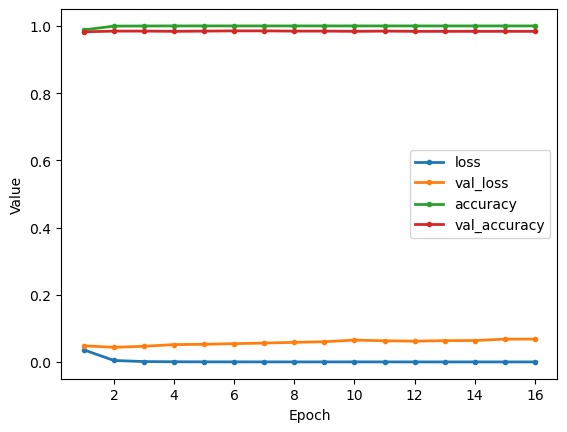

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step

 6/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

17/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

22/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

27/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

38/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step

 6/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

11/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

36/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/AP2/report_PCVCG5RB.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

In [ ]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [ ]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

In [ ]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [ ]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')

In [ ]:
# END

In [ ]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################